# Example 5.5 — Bayesian analysis of LED Accelerated Degradation with Dual Stresses

**Author:** Justin Ryan  
**Created:** 2025-09-24  
**Updated:** 2025-09-29  
**Version:** 1.1  

---
## Problem Statement
Repeat Example 5.3 using the Bayesian approach using the same degradation model. Also determine the 90% confidence of use level life.

Priors can be assumed as 

- $a \sim\mathcal{LN} (2\times 10^{-8},0.5)$
- $b \sim\mathcal{LN} (1,0.5)$
- $E_{a}\sim\mathcal{LN} (0.3,0.3)$
- $n \sim\mathcal{LN} (1.2,0.5)$
- $c \sim\mathcal{Uniform} (-0.1, 0.1)$ 
- $\sigma_\varepsilon\sim\mathcal{Uniform} (1\times 10^{-4},2) $

---

## Solution

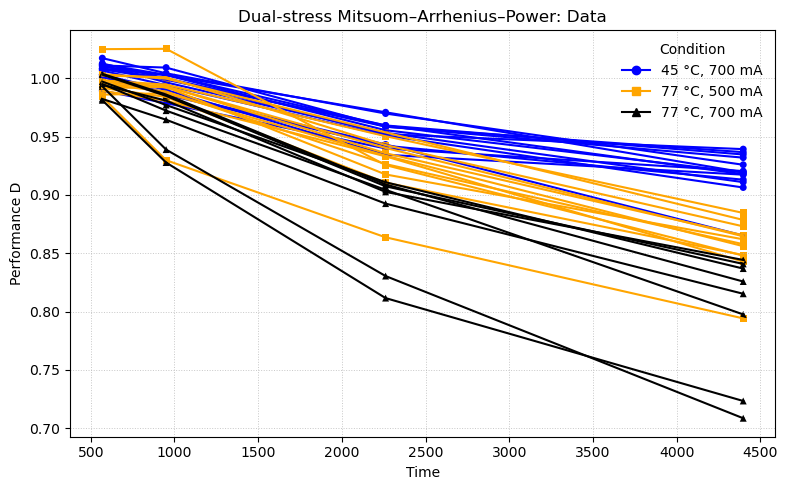

C:\Users/leaat/Dropbox/University of Maryland/ENRE648 - PPoF Chap Review - Degradation Analysis/ADT Fitters Module\ADT_fitters.py:2425: RuntimeWarning: overflow encountered in power
  return 1.0 / (1.0 + a * (base ** b))


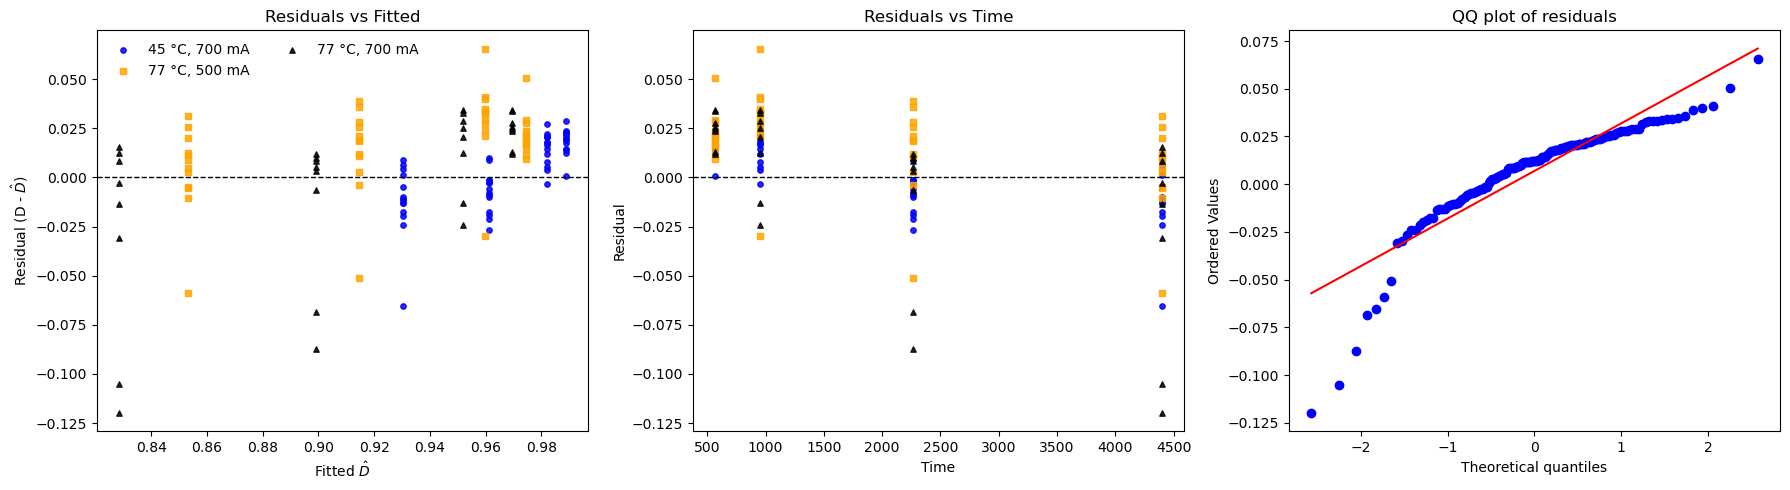

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 221.95it/s]


### Degradation / performance model

**Model form (performance scale)**

A Mitsuom-type *performance* model with Arrhenius temperature and
power-law stress acceleration:

$$
D(t, T, S)
= \left[
  1 + a \left(
    \exp\!\left(\frac{E_a}{k_B}
      \left(\frac{1}{T_{\text{use}}} - \frac{1}{T}\right)
    \right)
    \, S^{n} \, t
  \right)^{b}
\right]^{-1}.
$$

Here performance $D(t,T,S)$ typically starts near 1 and decreases
towards 0 as damage accumulates.

**Parameters:**

- **$a$** – scale factor on the accumulated damage term  
- **$b$** – time/curvature exponent (how sharply degradation accelerates)  
- **$E_{a}$** – Arrhenius activation energy (eV)  
- **$n$** – power exponent on the second stress \(S\) (e.g. current in mA)  
- **$T_{\text{use}}, S_{\text{use}}$** – fixed use-level stresses (inputs, not fitted)

### Bayesian (additive) Parameter Estimates (95% CrI)

| Parameter | Mean | Median | 95% CrI |
|-----------|------|--------|----------------|
| a | 2.40181e-07 | 2.16225e-07 | [3.91203e-08, 4.78773e-07] |
| b | 1.12103 | 1.14615 | [1.0137, 1.28503] |
| Ea (eV) | 0.224469 | 0.225194 | [0.168382, 0.292495] |
| n | 0.369422 | 0.370074 | [0.189638, 0.589614] |
| $\sigma$ | 0.0273916 | 0.0257915 | [0.0221521, 0.0298615] |

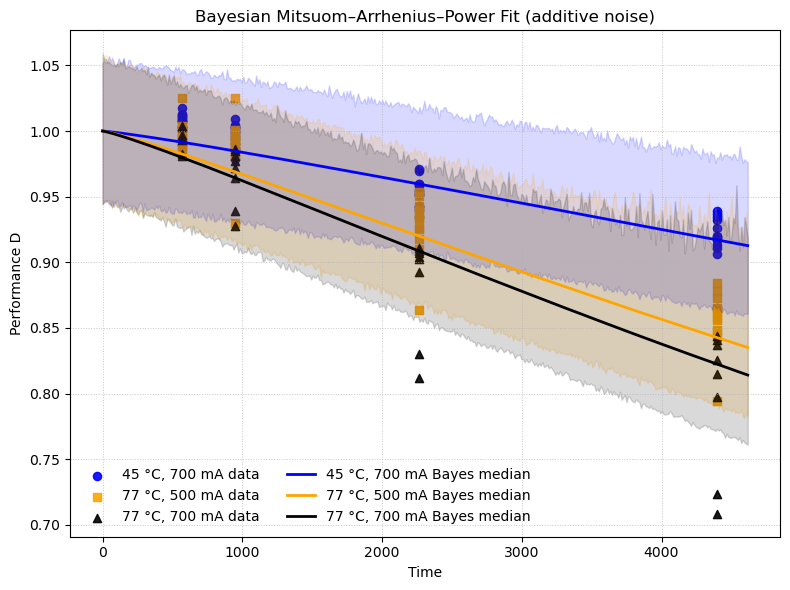

### Posterior summary for TTF at use (30 °C, 400 mA, Df=0.7) – Bayes

- Mean life: 3.2660e+04 time units
- Median life: 3.1532e+04 time units
- 95% HDI: [2.0185e+04, 4.6766e+04] time units
- 95% ETI: [2.1656e+04, 4.9784e+04] time units

c:\users\leaat\reliability\reliability\Fitters.py:440: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


Results from Fit_Everything:
Analysis method: MLE
Failures / Right censored: 7747/0 (0% right censored) 

   Distribution   Alpha    Beta   Gamma Alpha 1  Beta 1 Alpha 2  Beta 2 Proportion 1 DS      Mu    Sigma      Lambda  Log-likelihood   AICc    BIC      AD optimizer
   Lognormal_3P                  9381.7                                                 10.0092 0.302953                    -79282.8 158572 158592 0.70465       TNC
       Gamma_3P 2881.67 6.14748 14944.8                                                                                     -79303.1 158612 158633 2.60416       TNC
 Loglogistic_3P 20264.7 5.28756 11300.3                                                                                     -79322.3 158651 158671  3.7037       TNC
   Lognormal_2P                                                                         10.3708 0.212448                    -79334.7 158673 158687  6.8636  L-BFGS-B
 Loglogistic_2P 31743.6 8.29346                                      

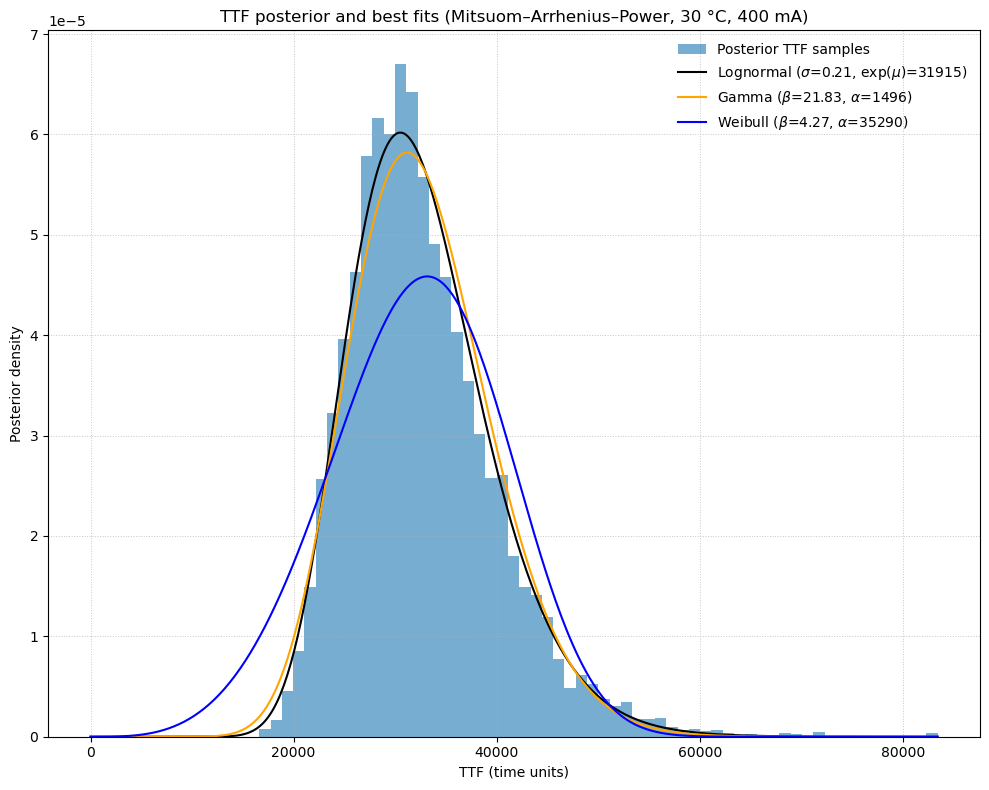

In [1]:
# EXAMPLE 5.5
import pandas as pd
import sys 
sys.path.append("C:/Users/leaat/Dropbox/University of Maryland/ENRE648 - PPoF Chap Review - Degradation Analysis/ADT Fitters Module")
df = pd.read_csv("C:/Users/leaat/Dropbox/University of Maryland/ENRE648 - PPoF Chap Review - Degradation Analysis/Modarres Chapter Validation/data/Example_5.3_LED_degradation_data.csv")

#Remove outlier units
df = df[~df["Unit"].isin([15, 22])].reset_index(drop=True)  #[3, 5, 15, 22]

# --- Tidy to long format: (Unit, T_C, I_mA, time_hr, D) ---
time_cols = [c for c in df.columns if "(hr)" in c]
df = df.melt(
    id_vars=["Unit", "T_C", "I_mA"],
    value_vars=time_cols,
    var_name="time_hr",
    value_name="D"
).dropna()
df["time_hr"] = df["time_hr"].str.extract(r"(\d+(?:\.\d+)?)").astype(float)
df = df.sort_values(["Unit", "time_hr"]).reset_index(drop=True)

T_use_C = 30    # deg C
I_use_mA = 400  # mA
Df = 0.70       # relative luminosity

priors = {
    "a":    ("Lognormal", -17.8, 0.2),
    "b":    ("Lognormal", -0.05, 0.2),
    "Ea":   ("Lognormal", -1.3, 0.3),
    "n":    ("Lognormal", -0.05, 0.2),
    "sigma":("Lognormal",    0.001, 0.1)}

from ADT_fitters import Fit_ADT_Mitsuom_Arrhenius_Power
fit_dual = Fit_ADT_Mitsuom_Arrhenius_Power(
    degradation=df["D"],
    temp_C=df["T_C"],
    stress_S=df["I_mA"],      # second stress array
    time=df["time_hr"],
    unit=df["Unit"],
    stress_use_T=T_use_C,
    stress_use_S=I_use_mA,      # e.g. use-level current
    Df=Df,
    CI=0.95,
    method="Bayesian",
    noise="additive",
    priors=priors,
    show_data_plot=True,
    show_LSQ_diagnostics=True,
    show_noise_bounds=True,
    show_use_TTF_dist=True,
    print_results=True,
)